In [80]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,RocCurveDisplay, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

In [81]:
df=pd.read_csv('train.csv')
dt=pd.read_csv('test.csv')

In [82]:
#Observamos que las ultimas 4 columnas tienen valores invalidos lo que puede generar problemas al modelo de entrenamiento
#remplazamos cada valor referido a esto
df.replace(-99,np.nan,inplace=True) #La función replace() es un método de Pandas que permite reemplazar valores específicos en un DataFrame o en una Serie.
#Ademas puede haber valores faltantes por lo que completamos eñ codigo con estos valores tomando la mediana de cada columna
df.fillna(df.median(),inplace=True) #es un método de Pandas que se utiliza para reemplazar los valores faltantes (NaN) en un DataFrame
df = df[(np.abs(zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]
#Observamos que las ultimas 4 columnas tienen valores invalidos lo que puede generar problemas al modelo de entrenamiento
#remplazamos cada valor referido a esto
dt.replace(-99,np.nan,inplace=True)
#Ademas puede haber valores faltantes por lo que completamos eñ codigo con estos valores tomando la mediana de cada columna
dt.fillna(dt.mean(),inplace=True)
#Repito lo de arriba pues si entreno testeo

In [83]:
df.set_index('ID',inplace=True)
dt.set_index('ID',inplace=True )

In [84]:
#Ahora, como queremos que diferencie entre estrella, galaxia o cuasar, utilizamos las magnitudes
Bandas=['umag','gmag','rmag','imag','zmag','Ymag','Jmag','Hmag','Kmag','W1mag','W2mag'] #Estas solas magnitudes totales
#Elegimos en principio estas bandas 
#La función len() devuelve la cantidad de elementos en una lista
for i in range(len(Bandas)-1):
    df[f'{Bandas[i]}-{Bandas[i+1]}']=df[Bandas[i]]-df[Bandas[i+1]]
    dt[f'{Bandas[i]}-{Bandas[i+1]}']=dt[Bandas[i]]-dt[Bandas[i+1]]
Bandas_rad=['u3mag','g3mag','r3mag','i3mag','Z3mag','Y3mag','J3mag','H3mag','K3mag']
#Ahora en la misma linea de codigo, haremos lo mismo para las magnitudes a radio constante 3arcsecond
for i in range(len(Bandas_rad)-1):
    df[f'{Bandas_rad[i]}-{Bandas_rad[i+1]}']=df[Bandas_rad[i]]-df[Bandas_rad[i+1]]
    dt[f'{Bandas_rad[i]}-{Bandas_rad[i+1]}']=dt[Bandas_rad[i]]-dt[Bandas_rad[i+1]]
Bandas_HLR=['Yhlr','Jhlr','Hhlr','Khlr']
for i in range(len(Bandas_HLR)-1):
    df[f'{Bandas_HLR[i]}-{Bandas_HLR[i+1]}']=df[Bandas_HLR[i]]-df[Bandas_HLR[i+1]]
    dt[f'{Bandas_HLR[i]}-{Bandas_HLR[i+1]}']=dt[Bandas_HLR[i]]-dt[Bandas_HLR[i+1]]
df['W1mag/W2mag'] = df['W1mag'] / df['W2mag']
df['umag/gmag'] = df['umag'] / df['gmag']
df['gmag/rmag'] = df['gmag'] / df['rmag']
df['rmag/imag'] = df['rmag'] / df['imag']
df['Hmag/Kmag'] = df['Hmag'] / df['Kmag']
df['Jmag/Hmag'] = df['Jmag'] / df['Hmag']
dt['W1mag/W2mag'] = dt['W1mag'] / dt['W2mag']
dt['umag/gmag'] = dt['umag'] / dt['gmag']
dt['gmag/rmag'] = dt['gmag'] / dt['rmag']
dt['rmag/imag'] = dt['rmag'] / dt['imag']
dt['Hmag/Kmag'] = dt['Hmag'] / dt['Kmag']
dt['Jmag/Hmag'] = dt['Jmag'] / dt['Hmag']

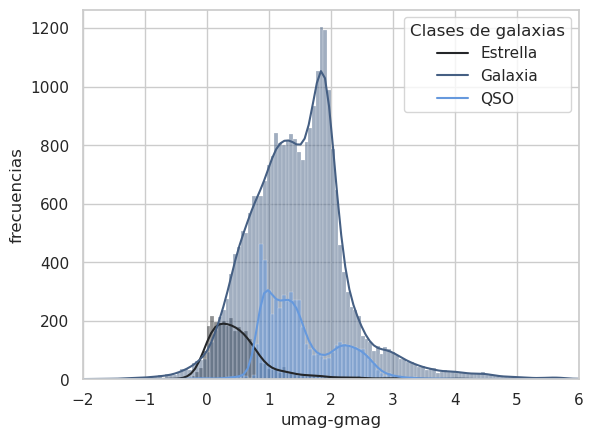

In [85]:
palette=sns.dark_palette("#69d", reverse=True, as_cmap=True)
sns.histplot(df, x='umag-gmag', hue='Hclass', kde=True, palette=palette)  
plt.xlim(-2,6)
plt.ylabel('frecuencias')

plt.legend(title='Clases de galaxias', labels=['Estrella', 'Galaxia', 'QSO'])
plt.show()

In [86]:
df['Hclass'].value_counts()

Hclass
1    27325
0     5714
2     3132
Name: count, dtype: int64

In [87]:
#Tengo que definir mis feature, mis variables de entrada, estas son las que utilizamos para entrenar el modelo
features = ['umag', 'gmag', 'rmag', 'imag', 'zmag', 'Ymag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 
            'umag-gmag', 'gmag-rmag', 'rmag-imag', 'imag-zmag', 'zmag-Ymag', 'Ymag-Jmag', 'Jmag-Hmag', 
            'Hmag-Kmag', 'W1mag-W2mag', 'g3mag-r3mag', 'r3mag-i3mag', 
            'i3mag-Z3mag', 'Z3mag-Y3mag', 'Y3mag-J3mag', 'J3mag-H3mag', 'H3mag-K3mag','W1mag/W2mag', 'umag/gmag', 'gmag/rmag', 'rmag/imag', 'Hmag/Kmag', 'Jmag/Hmag']
#Me quedo con mis mejores estimadores
#features = [
#            'umag-gmag', 'gmag-rmag', 'rmag-imag', 'Ymag-Jmag', 'Jmag-Hmag', 
#            'Hmag-Kmag', 'W1mag-W2mag', 'g3mag-r3mag', 'r3mag-i3mag',
#             'Z3mag-Y3mag', 'Y3mag-J3mag', 'J3mag-H3mag', 'H3mag-K3mag']

In [88]:
df_tr, df_te=train_test_split(df,test_size=0.3,random_state=42)
#Divide el conjunto de datos en entrenamiento (70%) y prueba (30%)

In [89]:
#Ahora dividimos en clases de entrenamiento
X_train = df_tr[features]
y_train = df_tr['Hclass']

#lo mismo con el testeo
X_test=df_te[features]
y_test=df_te['Hclass']

In [102]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Separar datos en entrenamiento y prueba
df_tr, df_te = train_test_split(df, test_size=0.3, random_state=42)

# Definir características y etiquetas
features = df.columns[:-1]  # Ajusta según el nombre de las columnas de tu dataset
X_train = df_tr[features]
y_train = df_tr['Hclass']
X_test = df_te[features]
y_test = df_te['Hclass']

# Escala las características para que tengan media 0 y desviación estándar 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce la dimensionalidad del conjunto de datos mientras retiene el 95% de la varianza
pca = PCA(n_components=0.95)  # Retener 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [103]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_pca, y_train)
y_pred = gbc.predict(X_test_pca)
print(" Reporte de clasificación ")
print(classification_report(y_test, y_pred))
print("Matriz de confusión ")
print(confusion_matrix(y_test, y_pred))
print( "Precisión general")
print(accuracy_score(y_test, y_pred))



 Reporte de clasificación 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1723
           1       0.99      0.99      0.99      8232
           2       0.96      0.93      0.95       897

    accuracy                           0.99     10852
   macro avg       0.98      0.97      0.98     10852
weighted avg       0.99      0.99      0.99     10852

Matriz de confusión 
[[1698   25    0]
 [  13 8183   36]
 [   0   60  837]]
Precisión general
0.9876520457058606


In [ ]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  
y_proba = gbc.predict_proba(X_test_pca)
roc_auc = roc_auc_score(y_test_bin, y_proba, average='weighted', multi_class="ovr")
print(f" ROC-AUC",roc_auc) 


/home/camila/miniconda3/envs/astrometria/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 53 features, but GradientBoostingClassifier is expecting 14 features as input.

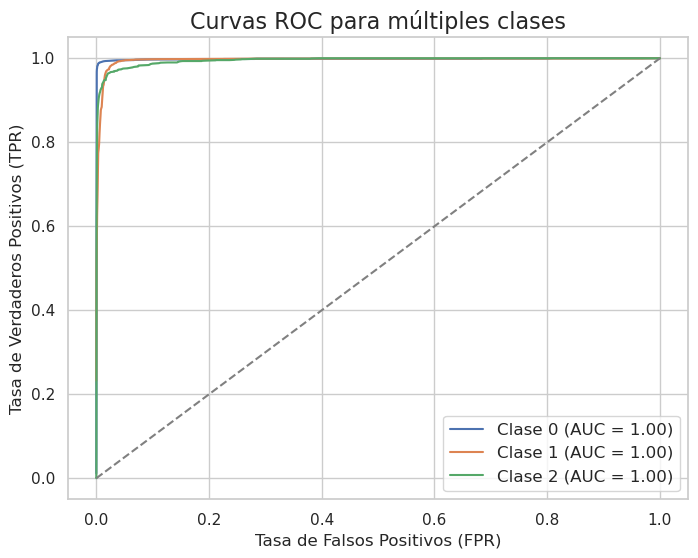

In [ ]:



# Suponiendo que y_test_bin es un array de etiquetas multilabel
# y_proba es un array de probabilidades para cada etiqueta
n_labels = y_test_bin.shape[1]  # Número de etiquetas
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_labels):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  # Calcular AUC para cada clase

# Graficar
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

for i in range(n_labels):
    sns.lineplot(x=fpr[i], y=tpr[i], label=f"Clase {i} (AUC = {roc_auc[i]:.2f})")

# Línea de referencia
sns.lineplot(x=[0, 1], y=[0, 1], color="gray", linestyle="--")
plt.title("Curvas ROC para múltiples clases", fontsize=16)
plt.xlabel("Tasa de Falsos Positivos (FPR)", fontsize=12)
plt.ylabel("Tasa de Verdaderos Positivos (TPR)", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [105]:
f1_score(y_test,y_pred,average='weighted')

0.9875994231004214

In [106]:
#Tengo que volver a preparar el conjunto submit
df_submit=pd.read_csv('test.csv')
df_submit.set_index('ID',inplace=True)

In [107]:
Bandas=['umag','gmag','rmag','imag','zmag','Ymag','Jmag','Hmag','Kmag','W1mag','W2mag'] #Estas solas magnitudes totales
#Elegimos en principio estas bandas 
#La función len() devuelve la cantidad de elementos en una lista
for i in range(len(Bandas)-1):
    df_submit[f'{Bandas[i]}-{Bandas[i+1]}']=df_submit[Bandas[i]]-df_submit[Bandas[i+1]]
    #dt[f'{Bandas[i]}-{Bandas[i+1]}']=dt[Bandas[i]]-dt[Bandas[i+1]]
Bandas_rad=['u3mag','g3mag','r3mag','i3mag','Z3mag','Y3mag','J3mag','H3mag','K3mag']
#Ahora en la misma linea de codigo, haremos lo mismo para las magnitudes a radio constante 3arcsecond
for i in range(len(Bandas_rad)-1):
    df_submit[f'{Bandas_rad[i]}-{Bandas_rad[i+1]}']=df_submit[Bandas_rad[i]]-df_submit[Bandas_rad[i+1]]
    #dt[f'{Bandas_rad[i]}-{Bandas_rad[i+1]}']=dt[Bandas_rad[i]]-dt[Bandas_rad[i+1]]
Bandas_HLR=['Yhlr','Jhlr','Hhlr','Khlr']
for i in range(len(Bandas_HLR)-1):
    df_submit[f'{Bandas_HLR[i]}-{Bandas_HLR[i+1]}']=df_submit[Bandas_HLR[i]]-df[Bandas_HLR[i+1]]
    #dt[f'{Bandas_HLR[i]}-{Bandas_HLR[i+1]}']=dt[Bandas_HLR[i]]-dt[Bandas_HLR[i+1]]
df_submit['W1mag/W2mag'] = df_submit['W1mag'] / df_submit['W2mag']
df_submit['umag/gmag'] = df_submit['umag'] / df_submit['gmag']
df_submit['gmag/rmag'] = df_submit['gmag'] / df_submit['rmag']
df_submit['rmag/imag'] = df_submit['rmag'] / df_submit['imag']
df_submit['Hmag/Kmag'] = df_submit['Hmag'] / df_submit['Kmag']
df_submit['Jmag/Hmag'] = df_submit['Jmag'] / df_submit['Hmag']

In [108]:
print(df_tr.columns)  # estas son las que uso para entrenar
print(df_submit.columns)  #Con esto imprimo las columnas del submir

Index(['RAdeg', 'DEdeg', 'Hclass', 'umag', 'gmag', 'rmag', 'imag', 'zmag',
       'Ymag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'u3mag', 'g3mag',
       'r3mag', 'i3mag', 'Z3mag', 'Y3mag', 'J3mag', 'H3mag', 'K3mag', 'Yhlr',
       'Jhlr', 'Hhlr', 'Khlr', 'umag-gmag', 'gmag-rmag', 'rmag-imag',
       'imag-zmag', 'zmag-Ymag', 'Ymag-Jmag', 'Jmag-Hmag', 'Hmag-Kmag',
       'Kmag-W1mag', 'W1mag-W2mag', 'u3mag-g3mag', 'g3mag-r3mag',
       'r3mag-i3mag', 'i3mag-Z3mag', 'Z3mag-Y3mag', 'Y3mag-J3mag',
       'J3mag-H3mag', 'H3mag-K3mag', 'Yhlr-Jhlr', 'Jhlr-Hhlr', 'Hhlr-Khlr',
       'W1mag/W2mag', 'umag/gmag', 'gmag/rmag', 'rmag/imag', 'Hmag/Kmag',
       'Jmag/Hmag'],
      dtype='object')
Index(['RAdeg', 'DEdeg', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'Ymag',
       'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'u3mag', 'g3mag', 'r3mag',
       'i3mag', 'Z3mag', 'Y3mag', 'J3mag', 'H3mag', 'K3mag', 'Yhlr', 'Jhlr',
       'Hhlr', 'Khlr', 'umag-gmag', 'gmag-rmag', 'rmag-imag', 'imag-zmag',
   

In [109]:
df_submit = df_submit[features]


KeyError: "['Hclass'] not in index"

In [ ]:
prediction= gbc.predict(df_submit)

/home/camila/miniconda3/envs/astrometria/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
df_submit['Hclass']=prediction

In [ ]:
df_submit.loc[:,['Hclass']].to_csv('submission.csv',index=True) #Este es el que queremos subir a la competencia
#Ahora deberia andar, creo